## Установка библиотек

In [2]:
!pip install gdown
!pip install py_essentials

## Импорт библиотек

In [1]:
from PIL import Image, ImageDraw
from tqdm import tqdm
from py_essentials import hashing as hs  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import gdown
import seaborn as sns
import cv2
import os

## Загрузка и распаковка данных

Создадим директорию для хранения датасета

In [3]:
!mkdir ./Data
%cd ./Data

Загрузим данные со страницы соревнования в Kaggle https://www.kaggle.com/c/skillbox-computer-vision-project

Тренировочный датасет:

In [4]:
url = 'https://drive.google.com/uc?id=1QdhIxh1QUEuLgRb7DWa7RA7CA08ybNRJ'
output = 'train.zip'
gdown.download(url, output, quiet=False)

Тестовый датасет:

In [5]:
url = 'https://drive.google.com/uc?id=1bGHeWeWYXj5biL9s-qTc9gyv91WNAbWE'
output = 'test_kaggle.zip'
gdown.download(url, output, quiet=False)

Установим необходимые библиотеки для загрузи данных с Kaggle, для этого потребуется kaggle.json 

In [6]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ # kaggle.json downloaded from kaggle
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permissions
!kaggle competitions download -c skillbox-computer-vision-project -p /content/drive/MyDrive/d_data/

Распакуем архивы с данными и определим переменную каталога c данными

In [7]:
data_folder = Path('./Data')

test_kaggle = zipfile.ZipFile(data_folder / 'test_kaggle.zip', 'r')
test_kaggle.extractall(data_folder)
test_kaggle.close()
    
train_kaggle = zipfile.ZipFile(data_folder / 'train.zip', 'r')
train_kaggle.extractall(data_folder)
train_kaggle.close()
    
train_csv = zipfile.ZipFile(data_folder / 'train.csv.zip', 'r')
train_csv.extractall(data_folder)
train_csv.close()

## EDA

Отобразим датафрейм с информацией о тренировочном датасете

In [8]:
df = pd.read_csv(data_folder / 'train.csv', index_col=0)
df = df.sort_values('image_path').reset_index(drop=True)
df.head()

image_path emotion
0     ./train/anger/0.jpg   anger
1     ./train/anger/1.jpg   anger
2    ./train/anger/10.jpg   anger
3   ./train/anger/100.jpg   anger
4  ./train/anger/1000.jpg   anger

Добавим дополнительные статистики в датафрейм, чтобы получить более полную информацию о датасете:
* ширина изображения
* высота изображения
* цветовая модель изображения
* hash файла (позволит удалить возможные дубликаты)
* пропорции изображения

In [9]:
image_info = []

for file in df.image_path:
    with Image.open(data_folder / file) as img:
        width, height = img.size
        mode = img.mode
        file_hash = hs.fileChecksum(data_folder / file, "sha256")    
        image_info.append((width, height, mode, file_hash))
        
print(f'Обработано {len(image_info)} файлов')

df['width'], df['height'], df['mode'], df['hash'] = zip(*image_info)
df['aspect_ratio'] = df['width'] / df['height']
df.head()

Обработано 50046 файлов


image_path emotion  width  height mode  \
0     ./train/anger/0.jpg   anger    183     183  RGB   
1     ./train/anger/1.jpg   anger    749     749  RGB   
2    ./train/anger/10.jpg   anger    261     261  RGB   
3   ./train/anger/100.jpg   anger    234     234  RGB   
4  ./train/anger/1000.jpg   anger    299     299  RGB   

                                                hash  aspect_ratio  
0  f9f2b64b4100e45239a9ad377d806a64fad7715a633ea9...           1.0  
1  fd6e42cafe8c7b85e005cb332a28ffd52c61c8405689b0...           1.0  
2  28d4a45b19b5d5228e7145bde353471bb86830e9d129e0...           1.0  
3  b5c8bfb19c5b0382aa593bc1d794f7f88963ea6f30c1b7...           1.0  
4  36f8ac496cfa036954b2ff69a09f7cfe1df7c408ad02e3...           1.0

Отобразим основные статистики

In [10]:
df.describe(include='all')

image_path emotion         width        height   mode  \
count                       50046   50046  50046.000000  50046.000000  50046   
unique                      50046       9           NaN           NaN      1   
top     ./train/surprise/6014.jpg   anger           NaN           NaN    RGB   
freq                            1    7022           NaN           NaN  50046   
mean                          NaN     NaN    523.587939    523.595452    NaN   
std                           NaN     NaN    425.017862    424.975074    NaN   
min                           NaN     NaN    133.000000    133.000000    NaN   
25%                           NaN     NaN    247.000000    247.000000    NaN   
50%                           NaN     NaN    371.000000    371.000000    NaN   
75%                           NaN     NaN    660.000000    660.000000    NaN   
max                           NaN     NaN   4689.000000   4689.000000    NaN   

                                                     hash  aspect_ratio  
count                                               50046  50046.000000  
unique                                              49310           NaN  
top     037456bc76b33139e6a5ebdb4004d18af696e9e8a91419...           NaN  
freq                                                   10           NaN  
mean                                                  NaN      0.999939  
std                                                   NaN      0.005394  
min                                                   NaN      0.833333  
25%                                                   NaN      1.000000  
50%                                                   NaN      1.000000  
75%                                                   NaN      1.000000  
max                                                   NaN      1.444354

Загружено 50046 изображений, все имеют цветовую палитру RGB

Согласно полученым статистикам, в датасете присутствую одинаковые изображения (изображение с идентичным хешем).
Удалим все дубликаты изображений в пределах одной эмоции

In [11]:
df.drop_duplicates(['hash', 'emotion'], inplace=True)

Обновим статистики после удаления дубликатов

In [12]:
df.describe(include='all')

image_path emotion         width        height   mode  \
count                       49508   49508  49508.000000  49508.000000  49508   
unique                      49508       9           NaN           NaN      1   
top     ./train/surprise/6014.jpg   anger           NaN           NaN    RGB   
freq                            1    6936           NaN           NaN  49508   
mean                          NaN     NaN    523.821564    523.829159    NaN   
std                           NaN     NaN    425.100901    425.057652    NaN   
min                           NaN     NaN    133.000000    133.000000    NaN   
25%                           NaN     NaN    247.000000    247.000000    NaN   
50%                           NaN     NaN    372.500000    372.000000    NaN   
75%                           NaN     NaN    660.000000    660.000000    NaN   
max                           NaN     NaN   4689.000000   4689.000000    NaN   

                                                     hash  aspect_ratio  
count                                               49508  49508.000000  
unique                                              49310           NaN  
top     4d4b09483adfa0d75ca72d803362b56ceac84ec14a253b...           NaN  
freq                                                    3           NaN  
mean                                                  NaN      0.999938  
std                                                   NaN      0.005423  
min                                                   NaN      0.833333  
25%                                                   NaN      1.000000  
50%                                                   NaN      1.000000  
75%                                                   NaN      1.000000  
max                                                   NaN      1.444354

Удалено 538 дубликатов изображений. В датасете остались идентичные изображения распределённые по разным эмоциям. Сортировка таких изображений возможна только вручную.

Отобразим в отдельном датафрейме изображения, относящиеся сразу к нескольким классам эмоций

In [13]:
df_dup = df.groupby('hash').agg({'emotion': 'unique', 'image_path' : 'unique'})
df_dup['emotion_count'] = df_dup['emotion'].apply(lambda x: len(x))
df_dup = df_dup[df_dup['emotion_count'] > 1]
df_dup

emotion  \
hash                                                                       
0100799dc68beb6091a60108e5dda99320dae97ad644b72...  [disgust, uncertain]   
034080de1b3efcc4248b42b9cf399690a29f23feaa3d98d...      [anger, disgust]   
03423b5f3d102c18a14654fded74ea431dbf089dac68bda...      [fear, surprise]   
037456bc76b33139e6a5ebdb4004d18af696e9e8a914193...      [fear, surprise]   
03c5070e2a0637c510742c665be60eecc9c324943f84a3a...         [anger, fear]   
...                                                                  ...   
f97f2c813f8a69324c21cbc406c763cd35b79946d001dbf...           [fear, sad]   
fb4994834947b9a856c4394165b94273c1503c698275a0e...      [anger, disgust]   
fb5b02da31d7886b3ca48f6ebb8456a9c91a18cd6aaecd6...      [anger, neutral]   
fb6ffaa8640ede21a728010bf1462646291b37fd87bb490...     [contempt, happy]   
fcf0eab478896cfa7db79eec48baaea2cddcead9c947c38...   [contempt, disgust]   

                                                                                           image_path  \
hash                                                                                                    
0100799dc68beb6091a60108e5dda99320dae97ad644b72...  [./train/disgust/2692.jpg, ./train/uncertain/1...   
034080de1b3efcc4248b42b9cf399690a29f23feaa3d98d...  [./train/anger/2292.jpg, ./train/disgust/1944....   
03423b5f3d102c18a14654fded74ea431dbf089dac68bda...  [./train/fear/2867.jpg, ./train/surprise/4820....   
037456bc76b33139e6a5ebdb4004d18af696e9e8a914193...  [./train/fear/1692.jpg, ./train/surprise/135.jpg]   
03c5070e2a0637c510742c665be60eecc9c324943f84a3a...     [./train/anger/2188.jpg, ./train/fear/783.jpg]   
...                                                                                               ...   
f97f2c813f8a69324c21cbc406c763cd35b79946d001dbf...      [./train/fear/4174.jpg, ./train/sad/3190.jpg]   
fb4994834947b9a856c4394165b94273c1503c698275a0e...  [./train/anger/541.jpg, ./train/disgust/2618.jpg]   
fb5b02da31d7886b3ca48f6ebb8456a9c91a18cd6aaecd6...  [./train/anger/2977.jpg, ./train/neutral/501.jpg]   
fb6ffaa8640ede21a728010bf1462646291b37fd87bb490...  [./train/contempt/1121.jpg, ./train/happy/4266...   
fcf0eab478896cfa7db79eec48baaea2cddcead9c947c38...  [./train/contempt/775.jpg, ./train/disgust/216...   

                                                    emotion_count  
hash                                                               
0100799dc68beb6091a60108e5dda99320dae97ad644b72...              2  
034080de1b3efcc4248b42b9cf399690a29f23feaa3d98d...              2  
03423b5f3d102c18a14654fded74ea431dbf089dac68bda...              2  
037456bc76b33139e6a5ebdb4004d18af696e9e8a914193...              2  
03c5070e2a0637c510742c665be60eecc9c324943f84a3a...              2  
...                                                           ...  
f97f2c813f8a69324c21cbc406c763cd35b79946d001dbf...              2  
fb4994834947b9a856c4394165b94273c1503c698275a0e...              2  
fb5b02da31d7886b3ca48f6ebb8456a9c91a18cd6aaecd6...              2  
fb6ffaa8640ede21a728010bf1462646291b37fd87bb490...              2  
fcf0eab478896cfa7db79eec48baaea2cddcead9c947c38...              2  

[193 rows x 3 columns]

Уникальных изображений, которые относятся одновременно к нескольким эмоциям - 193 штуки. Взглянем на несколько из них.

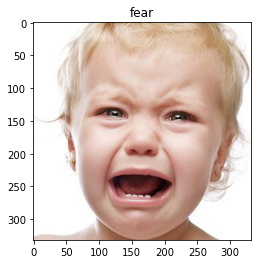

In [14]:
file = './train/fear/4174.jpg'
with Image.open(data_folder / file) as image:
    plt.imshow(image)
    plt.title('fear')
    plt.show()

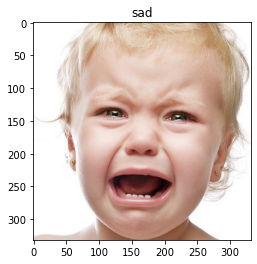

In [16]:
file = './train/sad/3190.jpg'
with Image.open(data_folder / file) as image:
    plt.imshow(image)
    plt.title('sad')
    plt.show()

Эти изображения можно отнести одновременно к нескольким классам, так как сложно однозначно определить эмоцию. В данном примере это может быть как страх так и грусть. Поэтому не будем удалять такие изображения.

Отобразим информацию о распределении изображений по классам эмоций

In [32]:
def show_emotion_distribution(dataframe, name:str):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.countplot(data=dataframe, x='emotion', ax=ax).set_title(f'Распределение изображений в датасете {name} по эмоциям')
    plt.grid(axis='y')
    plt.show()

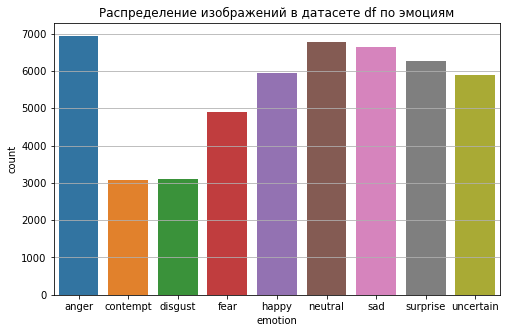

In [33]:
show_emotion_distribution(df, 'df')

На основе полученной диаграммы, можно сделать вывод, что датасет не сбалансирован. Имеется недостаток лиц в категориях contempt и disgust.

Построим гистограммы некоторых метрик

In [64]:
def show_proportions(dataframe):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.hist(dataframe.height, bins=20, color='green')
    plt.title('Гистрограмма размеров изображений')
    plt.xlabel('Высота, px')
    plt.ylabel('Количество')

    plt.subplot(1, 2, 2)
    plt.hist(dataframe.aspect_ratio, bins=40, log=True, color='green')
    plt.title('Гистограмма соотношений размеров')
    plt.xlabel('Пропорции')
    plt.ylabel('Количество')

    plt.show()

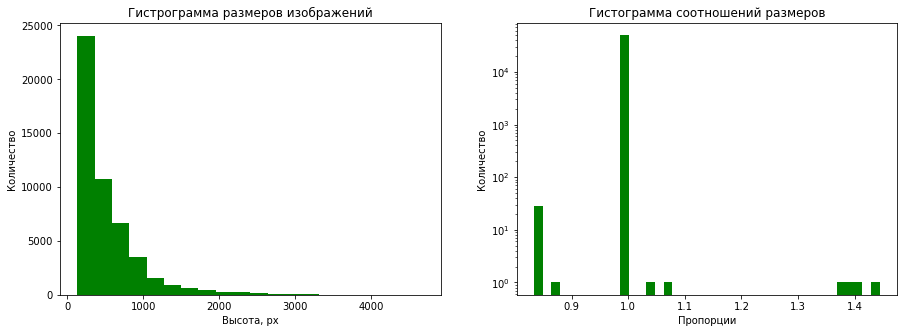

In [23]:
show_proportions(df)

Из гистограм и статистик становится понятно, что большинство изображений имеют не высокое разрешение и квадратные пропорции. Половина изображений имеет размер в пределах 247-660px, минимальный размер 133px, максимальный - 4689px.

Изучим более детально данные, для этого подготовим необходимые функции для детектирования лиц и отрисовки изображений

In [51]:
modelFile = "./res10_300x300_ssd_iter_140000.caffemodel"
configFile = "./deploy.prototxt"
detector = cv2.dnn.readNetFromCaffe(configFile, modelFile)

def get_boxes(gb_image):
    
    """The function starts the inference of the detector. It accepts an array as input
       and returns a list with coordinates of the bounding box """
    
    gb_height, gb_width = gb_image.shape[:2]
    conf_threshold = 0.9
    
    blob = cv2.dnn.blobFromImage(image=gb_image,
                                 scalefactor=1.0,
                                 size=(300, 300),
                                 mean=(104.0, 177.0, 123.0),
                                 swapRB=True)
    
    detector.setInput(blob)
    detections = detector.forward()
    
    gb_boxes = []
    for i_box in range(0, detections.shape[2]):
        confidence = detections[0, 0, i_box, 2]
        if confidence > conf_threshold:
            x_1 = int(detections[0, 0, i_box, 3] * gb_width)
            y_1 = int(detections[0, 0, i_box, 4] * gb_height)
            x_2 = int(detections[0, 0, i_box, 5] * gb_width)
            y_2 = int(detections[0, 0, i_box, 6] * gb_height)
            gb_boxes.append((x_1, y_1, x_2, y_2))
    return gb_boxes


def draw_boxes(db_image, db_boxes):
    
    """The function draws bounding boxes on image.
       It accepts an array as input and returns an image"""

    db_img = Image.fromarray(db_image)
    image_draw = ImageDraw.Draw(db_img)
    for bbox in db_boxes:
        x_1, y_1, x_2, y_2 = bbox
        image_draw.rectangle([x_1, y_1, x_2, y_2], fill=None, outline=(0,255,0), width=2)
    return db_img


def show_image(data, limit=100, show_labels=True, show_boxes=False, show_path=False):
    
    """The function displays images with the ability to render the bounding box
       and labels, but no more than specified in the limit.
       It accepts a slice of the dataframe with the specified file paths as input"""
    
    if data.shape[0] > limit:
        data = data.head(limit)
        
    grid_dim = np.ceil(np.sqrt(data.shape[0])).astype('int')
    plt.figure(figsize=(15, 15))
    
    for index, filepath in enumerate(data['image_path']):
        with Image.open(data_folder / filepath) as si_image:
            plt.subplot(grid_dim, grid_dim, index+1)
            if show_boxes:
                np_image = np.array(si_image)
                si_boxes = get_boxes(np_image)
                plt.imshow(draw_boxes(np_image, si_boxes))
            else:
                plt.imshow(si_image)
            if show_labels:
                plt.title(data['emotion'].iloc[index])
            if show_path:
                plt.title(data['image_path'].iloc[index])
            plt.xticks([])
            plt.yticks([])
    plt.show()

Сначала взглянем на изображения, имеющие портретную ориентацию

Всего обнаружено 29 изображений


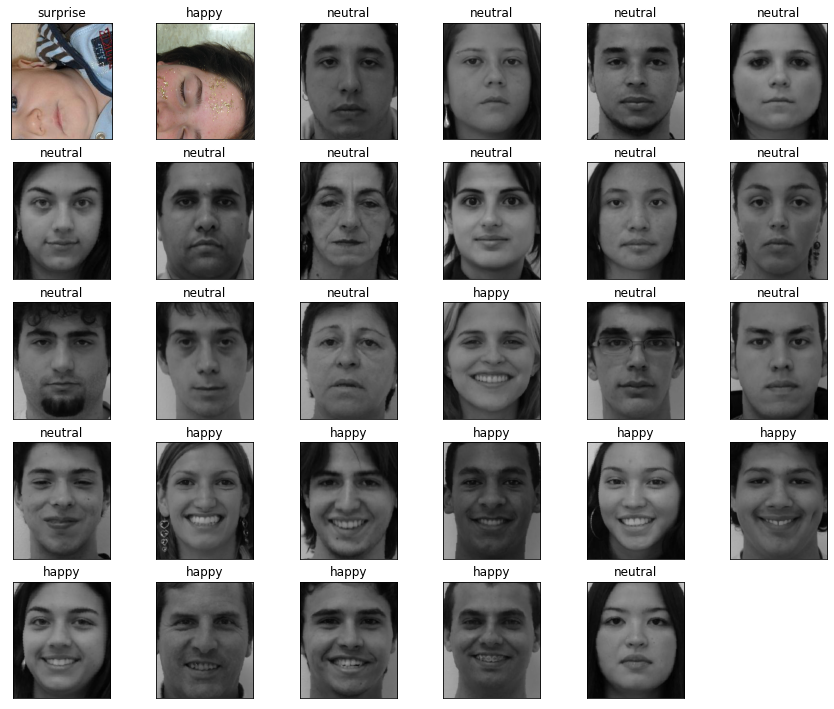

In [25]:
print(f"Всего обнаружено {sum(df['aspect_ratio'] < 1)} изображений")
portrait = df[df['aspect_ratio'] < 1].sort_values('aspect_ratio', ascending=False)
show_image(portrait)

Большинство изображений выглядит вполне нормально, но есть и несколько "выбросов", на которых нет изображения целого лица. При этом все оставшиеся изображения - чёрно-белые, не смотря на то, что имеют формат RGB.

Теперь взглянем на несколько фотографий с альбомными пропорциями

Всего обнаружено 6 изображений


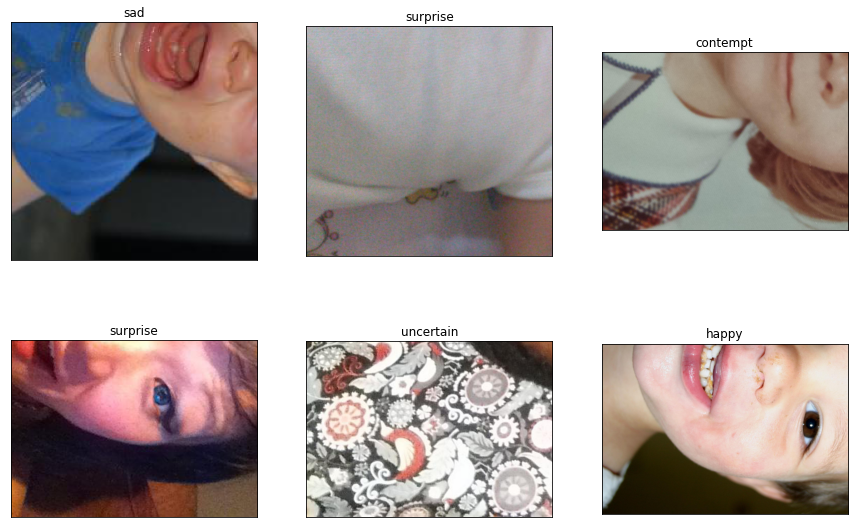

In [26]:
print(f"Всего обнаружено {sum(df['aspect_ratio'] > 1)} изображений")
album = df[df['aspect_ratio'] > 1].sort_values('aspect_ratio', ascending=True)
show_image(album)

В данном случае все изображения - "выбросы", так как на них лица повёрнуты на 90 градусов и сильно обрезаны

И небольшая подборка квадратных фотографий

Всего обнаружено 49473 изображений


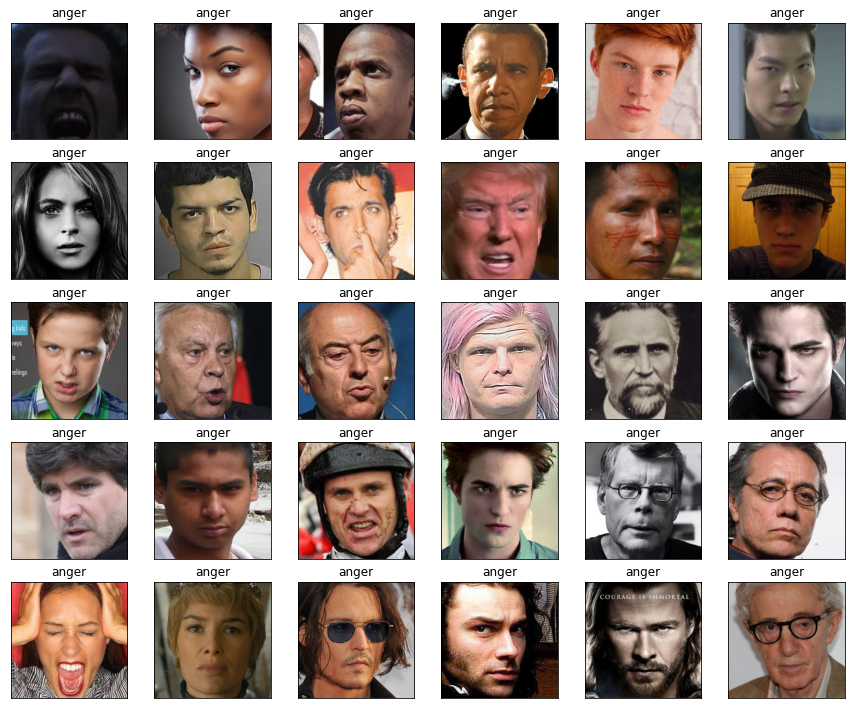

In [27]:
print(f"Всего обнаружено {sum(df['aspect_ratio'] == 1)} изображений")
square = df[df['aspect_ratio'] == 1]
show_image(square, limit=30)

Очевидно, что в датасете присутствуют изображения без лиц, либо с фрагментарным изображением лица. Возможно, на некотрых фотографиях лиц будет несколько. Чтобы это выяснить, пропустим изображения через детектор лиц - DNN Face Detector from OpenCV и сохраним полученный результат, сформировав столбец, с числом лиц найденных детектором.

In [28]:
face_count = []

for file in tqdm(df.image_path):
    with Image.open(data_folder / file) as image:
        img_np = np.array(image)
        boxes = get_boxes(img_np)
        face_count.append(len(boxes))

df['face_count'] = face_count
df.to_csv(data_folder / 'df.csv')  # save dataframe
df.head()

Загрузим сохранённый датафрейм

In [40]:
df = pd.read_csv(data_folder / 'df.csv', index_col=0)
df.head()

image_path emotion  width  height mode  \
0     ./train/anger/0.jpg   anger    183     183  RGB   
1     ./train/anger/1.jpg   anger    749     749  RGB   
2    ./train/anger/10.jpg   anger    261     261  RGB   
3   ./train/anger/100.jpg   anger    234     234  RGB   
4  ./train/anger/1000.jpg   anger    299     299  RGB   

                                                hash  aspect_ratio  face_count  
0  f9f2b64b4100e45239a9ad377d806a64fad7715a633ea9...           1.0           0  
1  fd6e42cafe8c7b85e005cb332a28ffd52c61c8405689b0...           1.0           1  
2  28d4a45b19b5d5228e7145bde353471bb86830e9d129e0...           1.0           1  
3  b5c8bfb19c5b0382aa593bc1d794f7f88963ea6f30c1b7...           1.0           1  
4  36f8ac496cfa036954b2ff69a09f7cfe1df7c408ad02e3...           1.0           1

Построим диаграмму по количеству лиц найденных на фото

In [57]:
def face_count(dataframe):
    plt.hist(x=dataframe, log=True, bins=30, color='green')
    plt.grid(axis='y')
    plt.title('Количество лиц, найденных на изображении')
    plt.xlabel('Количество лиц')
    plt.show()

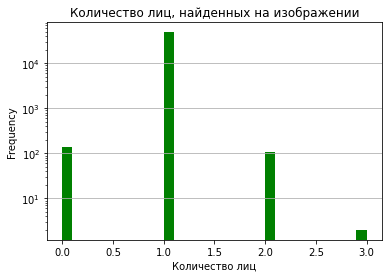

In [41]:
face_count(df['face_count'])

Посмотрим на изображения, на которых детектор не обнаружил лиц

Всего обнаружено 138 изображений


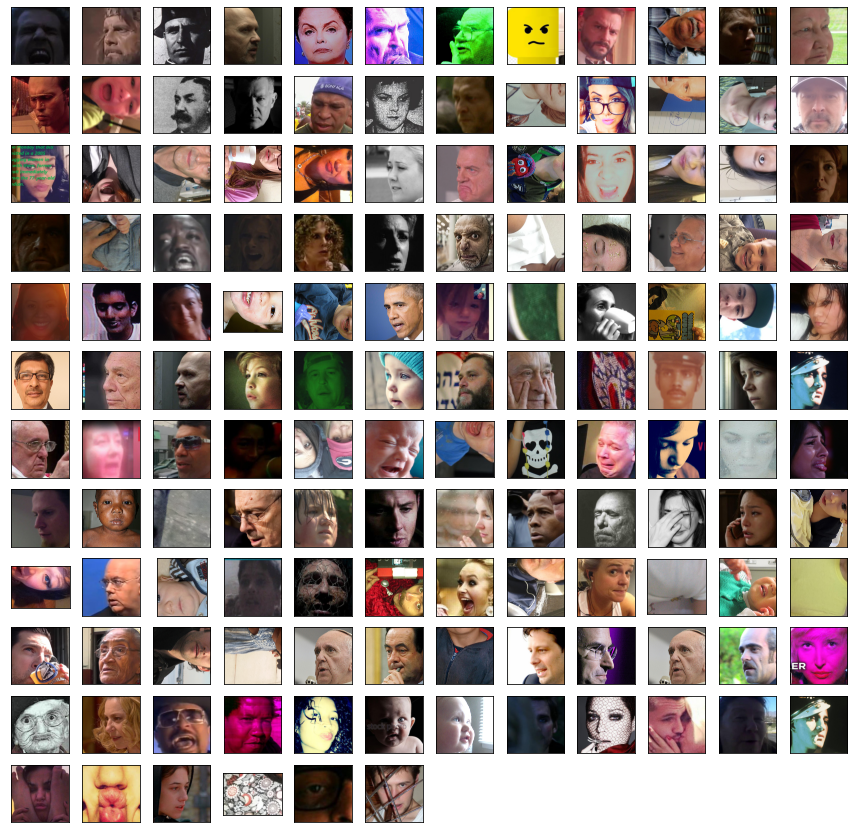

In [42]:
print(f"Всего обнаружено {sum(df['face_count'] == 0)} изображений")
without_faces = df[df['face_count'] == 0]
show_image(without_faces, limit=138, show_boxes=False, show_labels=False)

Детектор лиц не идеален и некоторые лица классифицированы неправильно. Исправим ошибки вручную, в том числе поворот некоторых фотографий

In [43]:
def rotate_photo(path:str, angle:int):
    with Image.open(data_folder / path) as rotated_image:
        rotated_image = rotated_image.rotate(angle)
        plt.imshow(rotated_image)
        plt.show()
        image.save(data_folder / path)

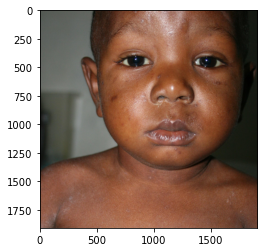

In [28]:
rotate_photo(path='./train/sad/4400.jpg', angle=270)

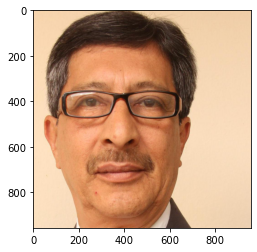

In [29]:
rotate_photo(path='./train/neutral/389.jpg', angle=270)

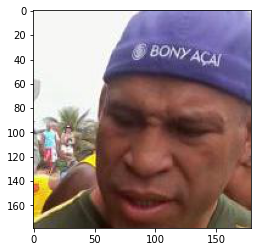

In [30]:
rotate_photo(path='./train/anger/6158.jpg', angle=90)

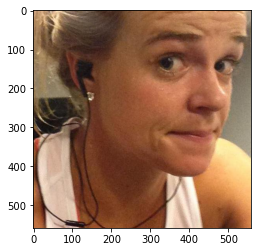

In [31]:
rotate_photo(path='./train/surprise/4016.jpg', angle=270)

Исправим значения изображений, на которых есть лица

In [44]:
good_images = ['./train/uncertain/1551.jpg', './train/uncertain/3359.jpg', './train/uncertain/1671.jpg',
          './train/uncertain/3265.jpg', './train/uncertain/2558.jpg', './train/uncertain/3500.jpg',
          './train/uncertain/3893.jpg', './train/uncertain/2580.jpg', './train/uncertain/530.jpg',
          './train/uncertain/4673.jpg', './train/uncertain/4487.jpg', './train/uncertain/3763.jpg',
          './train/uncertain/3588.jpg', './train/uncertain/2504.jpg', './train/uncertain/1196.jpg',
          './train/uncertain/4979.jpg', './train/uncertain/909.jpg', './train/uncertain/4990.jpg',
          './train/anger/1601.jpg', './train/anger/3342.jpg', './train/anger/13.jpg', './train/anger/1273.jpg',
          './train/anger/1688.jpg', './train/anger/0.jpg', './train/anger/1539.jpg', './train/anger/4146.jpg',
          './train/anger/4875.jpg', './train/anger/6220.jpg', './train/anger/5102.jpg', './train/anger/409.jpg',
          './train/anger/697.jpg', './train/anger/4080.jpg', './train/anger/2728.jpg', './train/anger/6158.jpg',
          './train/contempt/1852.jpg', './train/contempt/2808.jpg', './train/contempt/310.jpg',
          './train/disgust/2616.jpg', './train/disgust/2349.jpg', './train/disgust/2291.jpg', 
          './train/fear/1616.jpg', './train/fear/2182.jpg', './train/fear/4870.jpg', './train/fear/4833.jpg',
          './train/fear/3751.jpg', './train/fear/659.jpg', './train/fear/587.jpg', './train/happy/2135.jpg', 
          './train/happy/56.jpg', './train/happy/5405.jpg', './train/happy/5038.jpg', './train/neutral/1127.jpg',
          './train/neutral/1221.jpg', './train/neutral/2823.jpg', './train/neutral/4288.jpg', 
          './train/neutral/4635.jpg', './train/neutral/4739.jpg', './train/neutral/4888.jpg', 
          './train/neutral/5066.jpg', './train/neutral/5394.jpg', './train/neutral/4970.jpg',
          './train/neutral/6510.jpg', './train/neutral/6588.jpg', './train/neutral/5945.jpg',
          './train/neutral/6736.jpg', './train/neutral/389.jpg', './train/sad/3021.jpg',
          './train/sad/4101.jpg', './train/sad/430.jpg', './train/sad/3869.jpg', './train/sad/3767.jpg',
          './train/sad/3714.jpg', './train/sad/6428.jpg', './train/sad/5311.jpg', './train/sad/5110.jpg',
          './train/sad/4755.jpg', './train/sad/1665.jpg', './train/sad/78.jpg', './train/sad/6065.jpg', 
          './train/sad/6003.jpg', './train/sad/4400.jpg', './train/sad/1134.jpg', './train/surprise/2165.jpg',
          './train/surprise/5857.jpg', './train/surprise/3756.jpg', './train/surprise/2923.jpg', 
          './train/surprise/2823.jpg', './train/surprise/835.jpg', './train/surprise/4016.jpg',
          './train/surprise/5044.jpg', './train/surprise/6063.jpg']

for i in good_images:
    df.loc[(df['image_path'] == i), 'face_count'] = 1

Посмотрим на изображения без лиц после чистки

Всего обнаружено 47 изображений


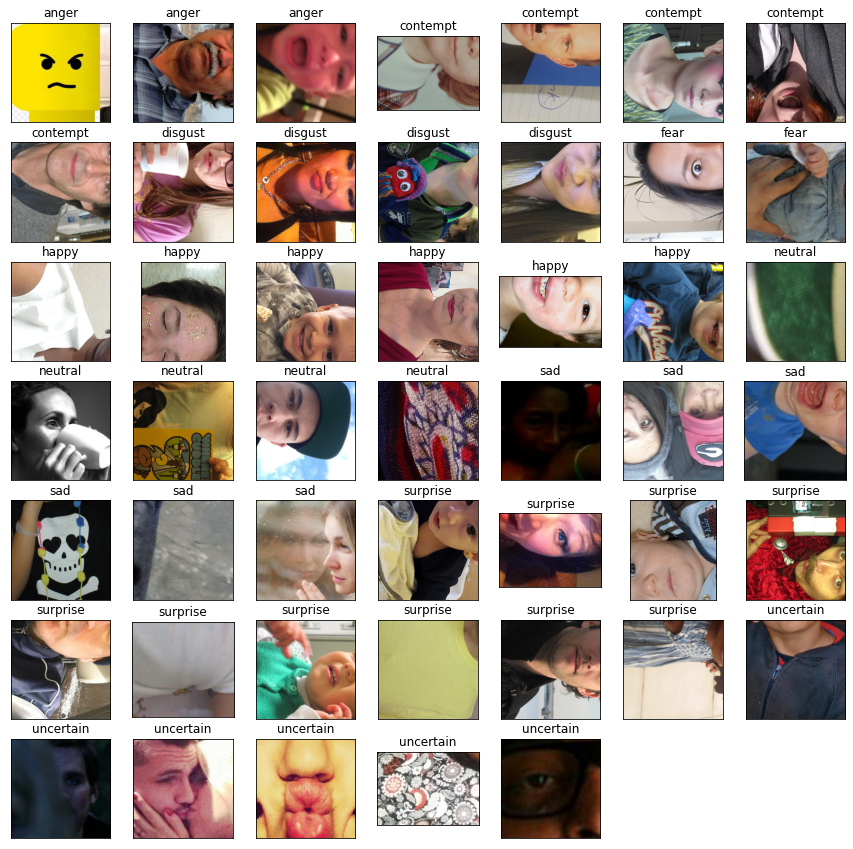

In [45]:
print(f"Всего обнаружено {sum(df['face_count'] == 0)} изображений")
without_faces = df[df['face_count'] == 0]
show_image(without_faces, limit=47, show_boxes=False, show_labels=True)

Остались только изображения, на которых нет лиц или лица попали в кадр не полностью

Сохраним очищенный датасет

In [46]:
df = df[df['face_count'] != 0].reset_index()
df.drop('index', inplace=True, axis=1)

In [47]:
df.to_csv(data_folder / 'df_cleared.csv')

In [48]:
df = pd.read_csv(data_folder / 'df_cleared.csv', index_col=0)
df.head()

image_path emotion  width  height mode  \
0     ./train/anger/0.jpg   anger    183     183  RGB   
1     ./train/anger/1.jpg   anger    749     749  RGB   
2    ./train/anger/10.jpg   anger    261     261  RGB   
3   ./train/anger/100.jpg   anger    234     234  RGB   
4  ./train/anger/1000.jpg   anger    299     299  RGB   

                                                hash  aspect_ratio  face_count  
0  f9f2b64b4100e45239a9ad377d806a64fad7715a633ea9...           1.0           1  
1  fd6e42cafe8c7b85e005cb332a28ffd52c61c8405689b0...           1.0           1  
2  28d4a45b19b5d5228e7145bde353471bb86830e9d129e0...           1.0           1  
3  b5c8bfb19c5b0382aa593bc1d794f7f88963ea6f30c1b7...           1.0           1  
4  36f8ac496cfa036954b2ff69a09f7cfe1df7c408ad02e3...           1.0           1

Действительно, в датасете присутствуют изображения с более чем одним лицом. Отобразим часть из них

Всего обнаружено 112 изображений


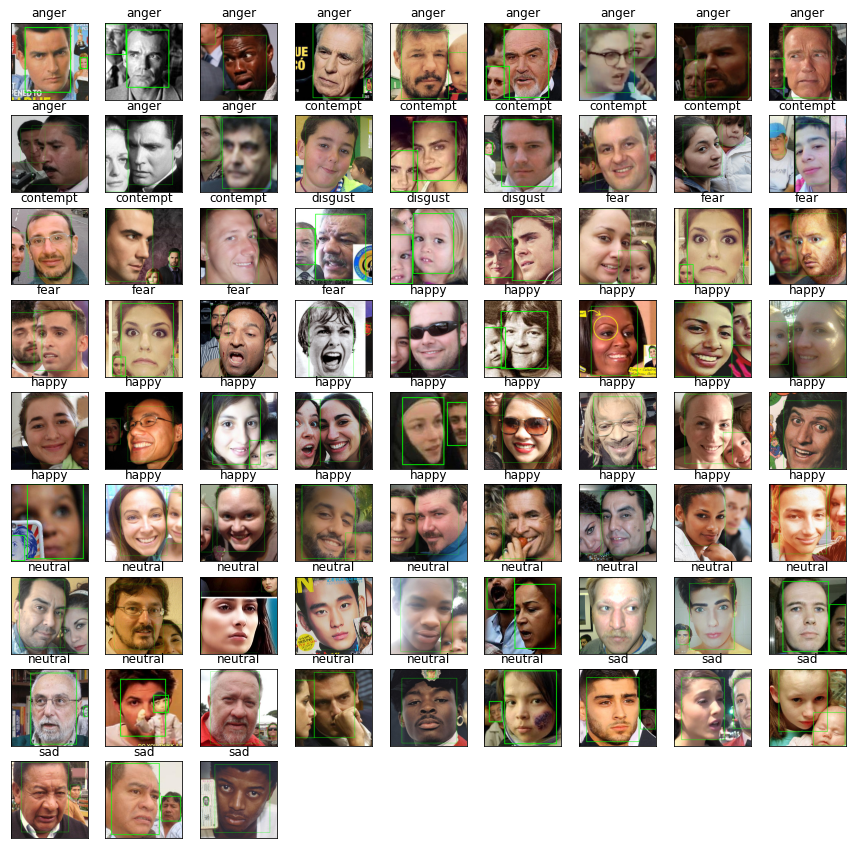

In [52]:
print(f"Всего обнаружено {sum(df['face_count'] > 1)} изображений")
more_the_one_face = df[df['face_count'] > 1]
show_image(more_the_one_face, limit=75, show_boxes=True, show_labels=True)


Подготовим альтернативный датасет, в котором все лица на изображениях будут обрезаны по bounding box и сохраним его в папке data_folder\cropped с учётом имени файла и структуры каталогов. Если лиц на изображении несколько, - вырежем лицо с самым большим bounding box. Это поможет решить проблему с несколькими лицами на одном изображении

In [54]:
!mkdir ./Data/cropped/
cropped_folder = data_folder / 'cropped'

In [44]:
cropped_list = []
max_box_indices = []

for i, file in tqdm(df['image_path'].items(), total=df.shape[0]):
    with Image.open(data_folder / file) as image:
        img_np = np.array(image)
        boxes = get_boxes(img_np)
        length = len(boxes)
        if length == 0:
            cropped_list.append((i, file, length))
        elif length == 1:
            cropped_list.append((i, file, length))
            x1, y1, x2, y2 = boxes[0]
            face = img_np[y1:y2, x1:x2]
            copy_dir = cropped_folder / Path(file).parent.name
            copy_dir.mkdir(exist_ok=True)
            file_name = copy_dir / Path(file).name
            Image.fromarray(face).save(file_name)
        elif length > 1:
            cropped_list.append((i, file, length))
            max_area = 0
            max_box_idx = 0
            for idx, box in enumerate(boxes):
                x1, y1, x2, y2 = box
                area = np.abs((x2 - x1) * (y2 - y1))
                if area > max_area:
                    max_area = area
                    max_box_idx = idx
            max_box_indices.append(max_box_idx)
            x1, y1, x2, y2 = boxes[max_box_idx]
            face = img_np[y1:y2, x1:x2]
            copy_dir = cropped_folder / Path(file).parent.name
            copy_dir.mkdir(exist_ok=True)
            file_name = copy_dir / Path(file).name
            Image.fromarray(face).save(file_name)

df_cropped = pd.DataFrame(cropped_list, columns=['index', 'image_path', 'face_count']).set_index('index')
df_cropped.to_csv(data_folder / 'df_cropped.csv')

100%|██████████| 49461/49461 [32:42<00:00, 25.20it/s] 


In [55]:
df_cropped = pd.read_csv(data_folder / 'df_cropped.csv', index_col=0)
df_cropped['image_path'] = df_cropped['image_path'].apply(lambda x: x.replace('train', 'cropped'))
df_cropped['emotion'] = df['emotion'].copy()
df_cropped.head()

image_path  face_count emotion
index                                              
0         ./cropped/anger/0.jpg           0   anger
1         ./cropped/anger/1.jpg           1   anger
2        ./cropped/anger/10.jpg           1   anger
3       ./cropped/anger/100.jpg           1   anger
4      ./cropped/anger/1000.jpg           1   anger

Построим диаграмму по количеству лиц найденных на фото

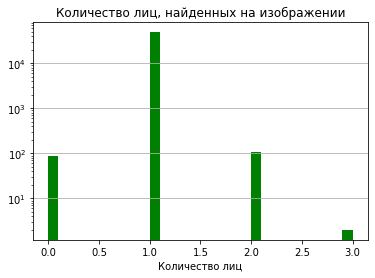

In [58]:
face_count(df_cropped['face_count'])

Удалим записи о изображениях без лиц

In [59]:
df_cropped = df_cropped[df_cropped['face_count'] != 0]
df_cropped.head()

image_path  face_count emotion
index                                              
1         ./cropped/anger/1.jpg           1   anger
2        ./cropped/anger/10.jpg           1   anger
3       ./cropped/anger/100.jpg           1   anger
4      ./cropped/anger/1000.jpg           1   anger
5      ./cropped/anger/1001.jpg           1   anger

Обновим статистики для альтернативного датасета

In [60]:
image_info = []

for file in df_cropped.image_path:
    with Image.open(data_folder / file) as img:
        width, height = img.size
        mode = img.mode  
        image_info.append((width, height, mode))
        
print(f'Обработано {len(image_info)} файлов')

df_cropped['width'], df_cropped['height'], df_cropped['mode'] = zip(*image_info)
df_cropped['aspect_ratio'] = df_cropped['width'] / df_cropped['height']
df_cropped.head()

Обработано 49373 файлов


image_path  face_count emotion  width  height mode  \
index                                                                     
1         ./cropped/anger/1.jpg           1   anger    527     731  RGB   
2        ./cropped/anger/10.jpg           1   anger    168     239  RGB   
3       ./cropped/anger/100.jpg           1   anger    144     211  RGB   
4      ./cropped/anger/1000.jpg           1   anger    207     253  RGB   
5      ./cropped/anger/1001.jpg           1   anger    145     208  RGB   

       aspect_ratio  
index                
1          0.720930  
2          0.702929  
3          0.682464  
4          0.818182  
5          0.697115

Отобразим основные статистики

In [61]:
df_cropped.describe(include='all')

image_path    face_count emotion         width  \
count                      49373  49373.000000   49373  49373.000000   
unique                     49373           NaN       9           NaN   
top     ./cropped/anger/5808.jpg           NaN   anger           NaN   
freq                           1           NaN    6917           NaN   
mean                         NaN      1.002309     NaN    349.519413   
std                          NaN      0.048833     NaN    286.805346   
min                          NaN      1.000000     NaN     58.000000   
25%                          NaN      1.000000     NaN    165.000000   
50%                          NaN      1.000000     NaN    253.000000   
75%                          NaN      1.000000     NaN    436.000000   
max                          NaN      3.000000     NaN   3520.000000   

              height   mode  aspect_ratio  
count   49373.000000  49373  49373.000000  
unique           NaN      1           NaN  
top              NaN    RGB           NaN  
freq             NaN  49373           NaN  
mean      464.223908    NaN      0.753895  
std       376.327440    NaN      0.077691  
min        85.000000    NaN      0.444444  
25%       220.000000    NaN      0.700000  
50%       334.000000    NaN      0.743682  
75%       582.000000    NaN      0.796545  
max      4679.000000    NaN      1.241758

In [62]:
df_cropped.to_csv(data_folder / 'df_cropped_cleared.csv')

Построим гистограммы пропорций изображений и их размеров

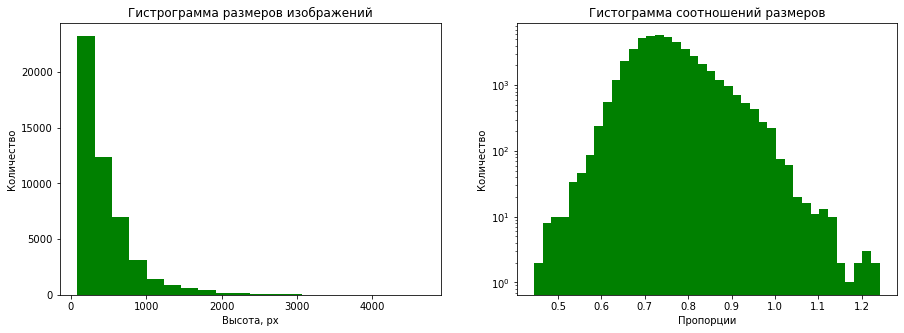

In [65]:
show_proportions(df_cropped)

Взглянем на лица, вырезанные из изображений с несколькими лицами

Всего обнаружено 112 изображений


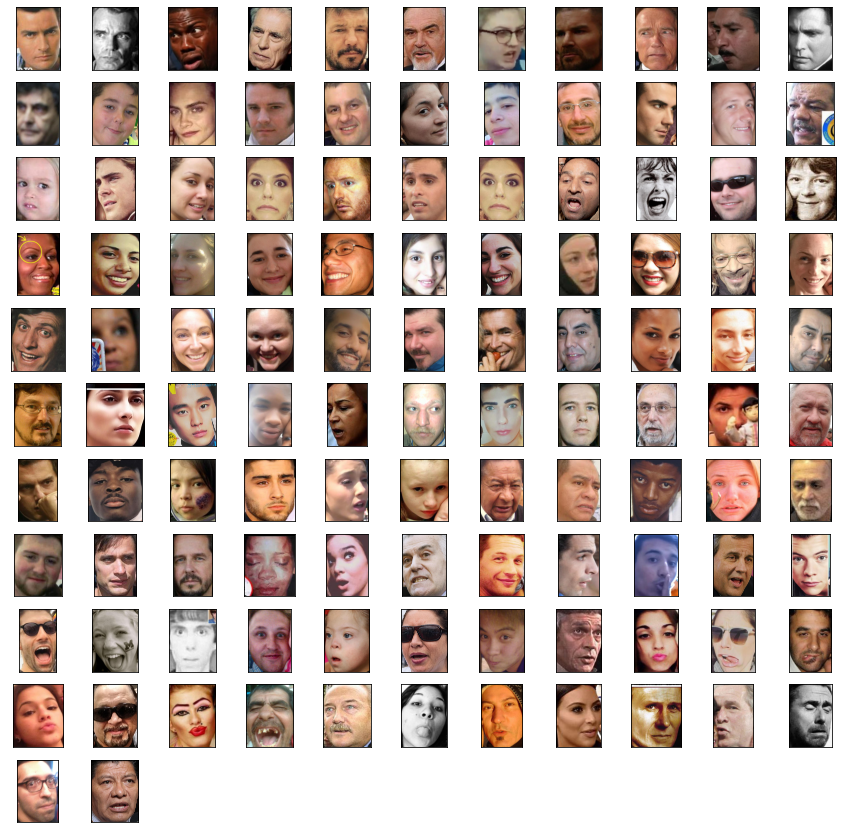

In [66]:
print(f"Всего обнаружено {sum(df_cropped['face_count'] > 1)} изображений")
cropped_more_then_one = df_cropped[df_cropped['face_count'] > 1]
show_image(cropped_more_then_one, limit=112, show_boxes=False, show_labels=False)

Обрезка прошла вполне корректно

Выведем на экран небольшую выборку лиц с изображений, на которых было всего одно лицо

Всего обнаружено 49261 изображений


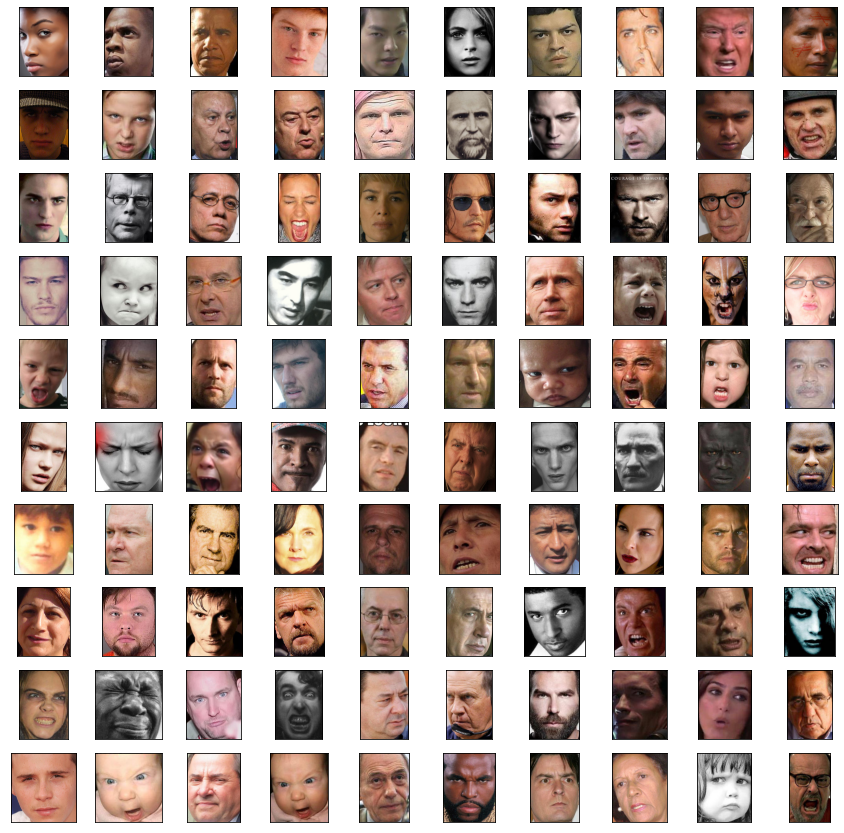

In [67]:
print(f"Всего обнаружено {sum(df_cropped['face_count'] == 1)} изображений")
just_one = df_cropped[df_cropped['face_count'] == 1]
show_image(just_one, limit=100, show_boxes=False, show_labels=False)

Здесь тоже всё в порядке

Построим диаграммы распределения эмоций по двум датасетам

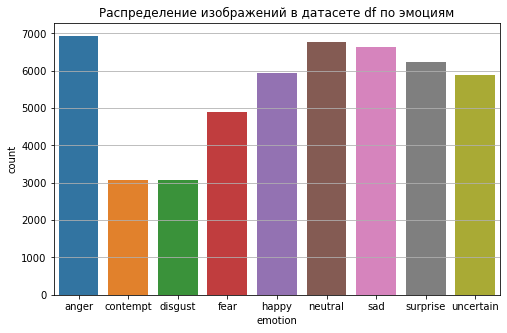

Размер датафрейма df: 49461


In [69]:
show_emotion_distribution(df, 'df')
print(f'Размер датафрейма df: {df.shape[0]}')

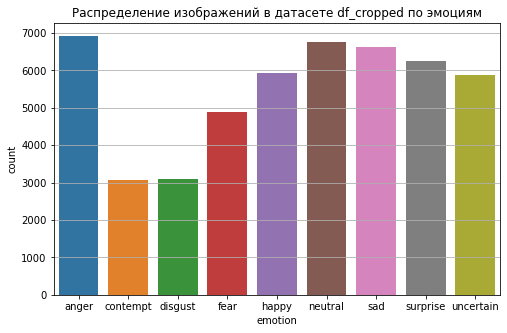

Размер датафрейма df_cropped: 49373


In [70]:
show_emotion_distribution(df_cropped, 'df_cropped')
print(f'Размер датафрейма df_cropped: {df_cropped.shape[0]}')

Пропорции распределения эмоций для двух датасетов практически идентичны

В итоге получим два датафрейма:
* датафрейм df с изображениями, на которых может быть несколько лиц, но все изображения без лиц удалены. Большинство изображений имеют квадратные пропорции, что минимизирует искажения при ресайзе. Датасет позволяет применять широкие возможности для аугментации
* датафрейм df_cropped, в котором все лица обрезаны по bounding_box. Если лиц на изображении несколько - обрезка осуществляется по самому большому из них. Все изображения отцентрированы по лицу, отсутствуют посторонние объекты, - только лица. Изображения имеют широкий диапазон пропорций, что может привести к искажениям при ресайзе. Возможности аугментации ограничены.

## Датасет для валидации на Kaggle

Подготовим датасет с изображениями для валидации на платфоме Kaggle

In [77]:
PATH_TEST = data_folder / 'test_kaggle'

In [78]:
def prepare_test_dataframe(path:str):

    """
    The function for preparing data for a dataframe
    with images for validation on Kaggle.
    It adds the width of the image, the height of the image,
    the path to the image. It returns a dictionary with the main
    image parameters.
    """

    ind = 0
    test_data = dict()
    for dir_path, _, filenames in os.walk(path):
        for path_image in filenames:
            test_image = os.path.abspath(os.path.join(dir_path, path_image))
            with Image.open(test_image) as test_img:
                test_width, test_height = test_img.size
                test_data[ind] = {
                    'image_path': path_image,
                    'width': test_width,
                    'height': test_height
                }
                ind += 1
    return test_data

In [80]:
df_test = pd.DataFrame(prepare_test_dataframe(PATH_TEST)).T
df_test = df_test.sort_values('image_path').reset_index(drop=True)
df_test = df_test.astype({'width': int, 'height': int})
df_test['aspect_ratio'] = df_test['width'] / df_test['height']
df_test.head()

image_path  width  height  aspect_ratio
0      0.jpg    300     300           1.0
1      1.jpg    547     547           1.0
2     10.jpg    254     254           1.0
3    100.jpg    902     902           1.0
4   1000.jpg    234     234           1.0

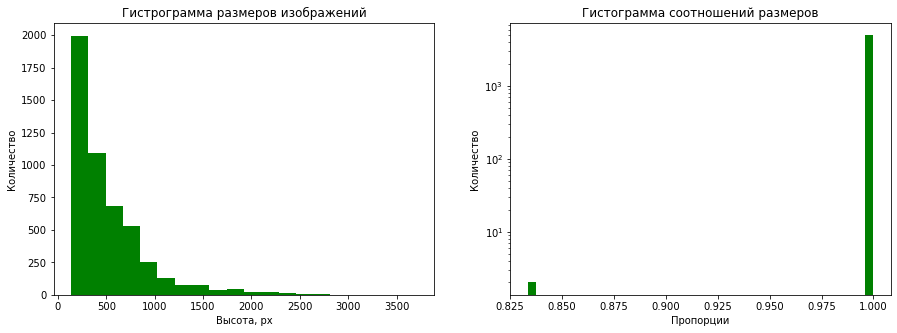

In [81]:
show_proportions(df_test)

Подавляющее большинство изображений имеет квадратные пропорции

Сохраним полученый датафрейм

In [82]:
df_test.to_csv(data_folder / 'df_test.csv')